## Interpretation of Hybrid VirProBERT attention values for multiclass classification

### Trainining Dataset: UniProt  - Coronaviridae Spike protein sequences (unaligned)
### Interpretation: SARS-CoV-2 Spike protein sequences

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: -

**Classification**: Multi-class

**\# classes**: 8

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/..']

In [2]:
from models.nlp.transformer import transformer
from models.nlp.hybrid import transformer_attention
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, dataset_utils, nn_utils, constants

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

In [3]:
label_groupings = {
                    "Pig": [ "sus scrofa" ],
                    "Human": [ "homo sapiens" ],
                    "Cat": [ "felis catus" ],
                    "Dromedary camel": [ "camelus dromedarius" ],
                    "Cattle": ["bos taurus"],
                    "Chicken": [ "gallus gallus" ],
                    "Gray wolf": [ "canis lupus" ],
                    "Yak": [ "bos grunniens" ]
                }


sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 1,
    "max_sequence_length": 256,
    "truncate": False,
    "split_sequence": False,
    "feature_type": "token",
}

label_settings = {
    "label_col": "virus_host_name",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "pre_train_settings": {
        "n_heads": 8,
        "depth": 6,
        "input_dim": 512, # input embedding dimension
        "hidden_dim": 1024,
        "max_seq_len": 256,
    },
    "loss": "FocalLoss",
    "n_heads": 8,
    "depth": 2,
    "stride": 64,
    "n_classes": 8,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "cls_token": False
}

### Load the datasets

In [4]:
def print_dataset_loader(dataset_loader):
    print()
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")

In [5]:
input_file_path = os.path.join(os.getcwd(), "..", "..", "..", "input/data/coronaviridae/20240313/sarscov2/uniprot/variants/sarscov2_variants_s.csv")
sarscov2_variants_df = pd.read_csv(input_file_path)
wiv04_seq_df = sarscov2_variants_df[sarscov2_variants_df["id"] == "WIV04"]
sarscov2_variants_df

,id,seq,virus_host_name
0,WIV04,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
1,QQM19141.1,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
2,QQX30509.1,VNXXTRTQLXXXXXXXXTRGVYYPDKVFRSSVLHSTQDLFLPFFSN...,homo sapiens
3,QRF70806.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
4,QRN78347.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
5,QRX39425.1,MFVFLVLLPLVSSQCVNFTNRTQLPSAYTNSFTRGVYYPDKVFRSS...,homo sapiens
6,QRX49325.1,MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
7,QTJ90974.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
8,QTY83052.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens
9,QUD52764.1,MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSS...,homo sapiens


In [6]:
index_label_map, dataset_loader = dataset_utils.load_dataset_with_df(sarscov2_variants_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")
print_dataset_loader(dataset_loader)

Grouping labels using config : {'Pig': ['sus scrofa'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Dromedary camel': ['camelus dromedarius'], 'Cattle': ['bos taurus'], 'Chicken': ['gallus gallus'], 'Gray wolf': ['canis lupus'], 'Yak': ['bos grunniens']}
label_idx_map={'Cat': 0, 'Cattle': 1, 'Chicken': 2, 'Dromedary camel': 3, 'Gray wolf': 4, 'Human': 5, 'Pig': 6, 'Yak': 7}
idx_label_map={0: 'Cat', 1: 'Cattle', 2: 'Chicken', 3: 'Dromedary camel', 4: 'Gray wolf', 5: 'Human', 6: 'Pig', 7: 'Yak'}

Sequence tensor size = torch.Size([1, 1269])
Sequence = tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64)
Label tensor size = torch.Size([1])
Label = tensor([5])


### Load the pre-trained and fine-tuned model

In [7]:
pre_train_encoder_settings = model["pre_train_settings"]
pre_train_encoder_settings["vocab_size"] = constants.VOCAB_SIZE
pre_trained_encoder_model = transformer.get_transformer_encoder(pre_train_encoder_settings)

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(30, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0): ResidualConnectionLayer(
            (layer_norm): LayerNormalization()
          )
          (1): ResidualConnectionLayer(
            (layer_norm): LayerNormalization()
          )
        )
    

In [8]:
model["pre_trained_model"] = pre_trained_encoder_model
model["segment_len"] = sequence_settings["max_sequence_length"]
prediction_model = transformer_attention.get_model(model)

TransformerAttention(
  (pre_trained_model): TransformerEncoder(
    (embedding): EmbeddingLayer(
      (token_embedding): Embedding(30, 512)
      (positional_embedding): PositionalEncoding()
    )
    (encoder): Encoder(
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiHeadAttention(
            (W_Q): Linear(in_features=512, out_features=512, bias=True)
            (W_K): Linear(in_features=512, out_features=512, bias=True)
            (W_V): Linear(in_features=512, out_features=512, bias=True)
            (W_O): Linear(in_features=512, out_features=512, bias=True)
          )
          (feed_forward): FeedForwardLayer(
            (W_1): Linear(in_features=512, out_features=1024, bias=True)
            (W_2): Linear(in_features=1024, out_features=512, bias=True)
          )
          (residual_connections): ModuleList(
            (0): ResidualConnectionLayer(
              (layer_norm): LayerNormalization()
            )
            (1): ResidualC

In [37]:
model_path = os.path.join(os.getcwd(), "..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240823/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_itr4.pth")
prediction_model.load_state_dict(torch.load(model_path, map_location=nn_utils.get_device()))

FileNotFoundError: [Errno 2] No such file or directory: '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/../../../output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240823/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl128b1024vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_itr4.pth'

### t-SNE Analysis

In [10]:
def compute_embeddings(model, dataset_loader):
    model.eval()
    seq_dfs = []
    for _, record in enumerate(dataset_loader):
        seq, label = record
        output = model(seq)
        # embedding = value for each dimension = mean of the dimensional values of all tokens in the input sequence
        seq_encoding = model.embedding
        seq_df = pd.DataFrame(seq_encoding.squeeze().cpu().detach().numpy())
        seq_df["label"] = label.squeeze().cpu().detach().numpy()
        print(seq_df.shape)
        seq_dfs.append(seq_df)
    df = pd.concat(seq_dfs)
    print(df.shape)
    return df

def view_tsne_representation(rep_df, index_label_map):
    columns = rep_df.columns
    print(columns)
    X = rep_df[range(512)]
    tsne_model = TSNE(n_components=2, verbose=1, init="pca", learning_rate="auto").fit(X)
    X_tsne_emb = pd.DataFrame(tsne_model.fit_transform(X))
    print(X_tsne_emb.shape)
    print(X_tsne_emb)
    X_tsne_emb["label"] = rep_df["label"].values
    X_tsne_emb["label"] = X_tsne_emb["label"].map(index_label_map)
    
    sns.scatterplot(data = X_tsne_emb, x=0, y=1, hue="label")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    return tsne_model, X_tsne_emb

In [11]:
#emb_df = compute_embeddings(prediction_model, dataset_loader)

### Attention value Analysis

In [12]:
def analyze_attention_of_sequence(model, seq):
    print(f"sequence length = {seq_len}")
    model.eval()
    output = model(seq)
    

In [13]:
sarscov2_variants_df

,id,seq,virus_host_name
0,WIV04,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
1,QQM19141.1,MFVFLVLLPLVSIQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
2,QQX30509.1,VNXXTRTQLXXXXXXXXTRGVYYPDKVFRSSVLHSTQDLFLPFFSN...,5
3,QRF70806.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
4,QRN78347.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
5,QRX39425.1,MFVFLVLLPLVSSQCVNFTNRTQLPSAYTNSFTRGVYYPDKVFRSS...,5
6,QRX49325.1,MFVFFVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
7,QTJ90974.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
8,QTY83052.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5
9,QUD52764.1,MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSS...,5


In [14]:
sequence_settings["batch_size"] = 1
sequence_settings["max_sequence_length"] = 256

_, wiv04_seq_df_dataset_loader = dataset_utils.load_dataset_with_df(wiv04_seq_df, sequence_settings, label_settings, label_col=label_settings["label_col"], classification_type="multi")

Grouping labels using config : {'Pig': ['sus scrofa'], 'Human': ['homo sapiens'], 'Cat': ['felis catus'], 'Dromedary camel': ['camelus dromedarius'], 'Cattle': ['bos taurus'], 'Chicken': ['gallus gallus'], 'Gray wolf': ['canis lupus'], 'Yak': ['bos grunniens']}
label_idx_map={'Cat': 0, 'Cattle': 1, 'Chicken': 2, 'Dromedary camel': 3, 'Gray wolf': 4, 'Human': 5, 'Pig': 6, 'Yak': 7}
idx_label_map={0: 'Cat', 1: 'Cattle', 2: 'Chicken', 3: 'Dromedary camel', 4: 'Gray wolf', 5: 'Human', 6: 'Pig', 7: 'Yak'}


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretability/../../utils/utils.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [15]:
prediction_model.eval()
input, label = next(iter(dataset_loader))

In [16]:
for item in iter(dataset_loader):
    print(item)

(tensor([[13., 14.,  8.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64), tensor([5]))
(ten

In [17]:
input, label = next(iter(dataset_loader))
input

tensor([[13., 14., 22.,  ...,  9., 21., 19.]], dtype=torch.float64)

In [18]:
label

tensor([5])

In [19]:
output = prediction_model(input)

In [20]:
output

tensor([[ 3.5971, -6.3380, -1.5549,  2.1072, -3.9481,  6.6126,  2.1390, -9.5496]],
       grad_fn=<AddmmBackward0>)

In [21]:
label

tensor([5])

In [22]:
F.softmax(output, dim=1)

tensor([[4.5738e-02, 2.2156e-06, 2.6471e-04, 1.0308e-02, 2.4178e-05, 9.3302e-01,
         1.0641e-02, 8.9268e-08]], grad_fn=<SoftmaxBackward0>)

In [23]:
prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn.shape

torch.Size([16, 8, 256, 256])

In [24]:
prediction_model.self_attn.self_attn.squeeze().shape

torch.Size([8, 16, 16])

In [25]:
pos_mapping = {}
j = 0
for i in range(1, len(wiv04_seq_df["seq"][0])+1, 64):
    try:
        start = i
        # end = seq_len if i+127 > seq_len else i+127
        end = i + 255
        pos_mapping[j] = f"{j}: {start}-{end}"
    except KeyError:
        break
    j += 1

In [26]:
pos_mapping

{0: '0: 1-256',
 1: '1: 65-320',
 2: '2: 129-384',
 3: '3: 193-448',
 4: '4: 257-512',
 5: '5: 321-576',
 6: '6: 385-640',
 7: '7: 449-704',
 8: '8: 513-768',
 9: '9: 577-832',
 10: '10: 641-896',
 11: '11: 705-960',
 12: '12: 769-1024',
 13: '13: 833-1088',
 14: '14: 897-1152',
 15: '15: 961-1216',
 16: '16: 1025-1280',
 17: '17: 1089-1344',
 18: '18: 1153-1408',
 19: '19: 1217-1472'}

In [27]:
inter_seg_attn = prediction_model.self_attn.self_attn.squeeze()

<Figure size 432x288 with 0 Axes>

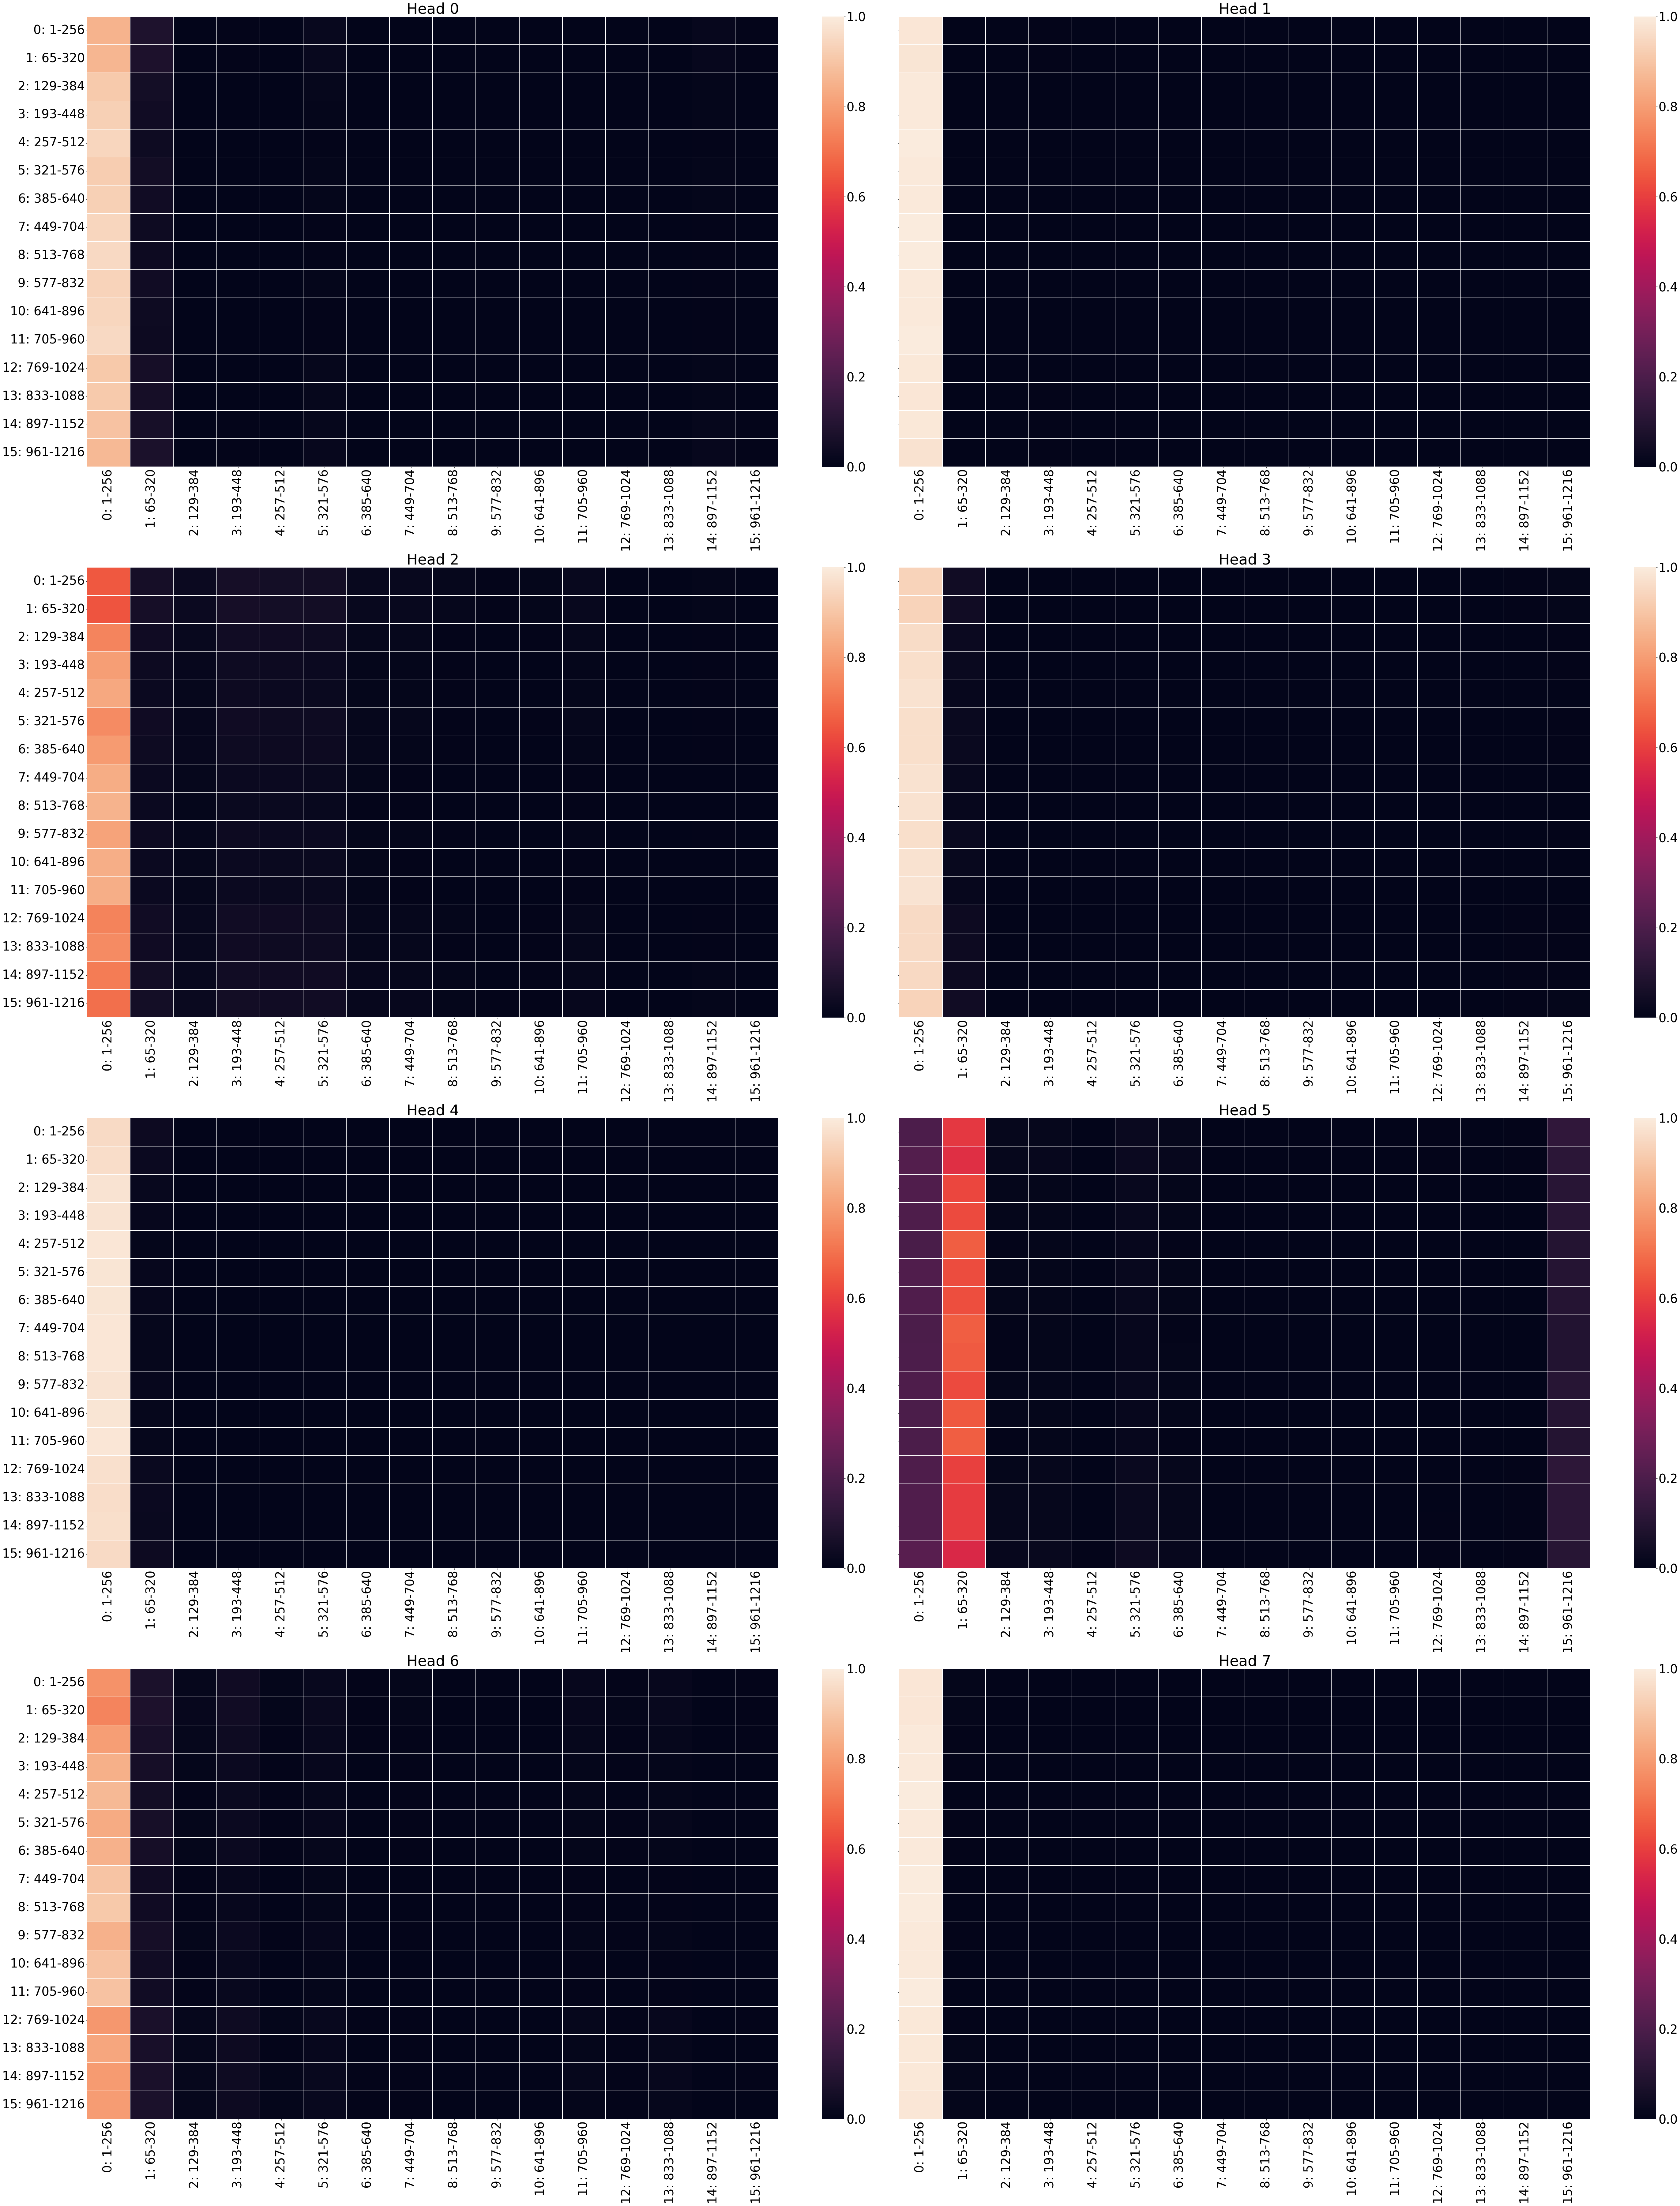

In [28]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=True)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(inter_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=pos_mapping, inplace=True)
        df.rename(index=pos_mapping, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1, vmin=0, vmax=1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()

In [33]:
intra_seg_index = 0
intra_seg_attn = prediction_model.pre_trained_model.encoder.layers[-1].self_attn.self_attn[intra_seg_index].squeeze()

In [34]:
intra_seg_attn.shape

torch.Size([8, 256, 256])

In [35]:
intra_seg_pos_map = {}
intra_seg_start = intra_seg_index * 64 + 1
intra_seg_end = intra_seg_start + 256

c = 0
for i in range(intra_seg_start, intra_seg_end):
    intra_seg_pos_map[c] = i
    c += 1

intra_seg_pos_map

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 11: 12,
 12: 13,
 13: 14,
 14: 15,
 15: 16,
 16: 17,
 17: 18,
 18: 19,
 19: 20,
 20: 21,
 21: 22,
 22: 23,
 23: 24,
 24: 25,
 25: 26,
 26: 27,
 27: 28,
 28: 29,
 29: 30,
 30: 31,
 31: 32,
 32: 33,
 33: 34,
 34: 35,
 35: 36,
 36: 37,
 37: 38,
 38: 39,
 39: 40,
 40: 41,
 41: 42,
 42: 43,
 43: 44,
 44: 45,
 45: 46,
 46: 47,
 47: 48,
 48: 49,
 49: 50,
 50: 51,
 51: 52,
 52: 53,
 53: 54,
 54: 55,
 55: 56,
 56: 57,
 57: 58,
 58: 59,
 59: 60,
 60: 61,
 61: 62,
 62: 63,
 63: 64,
 64: 65,
 65: 66,
 66: 67,
 67: 68,
 68: 69,
 69: 70,
 70: 71,
 71: 72,
 72: 73,
 73: 74,
 74: 75,
 75: 76,
 76: 77,
 77: 78,
 78: 79,
 79: 80,
 80: 81,
 81: 82,
 82: 83,
 83: 84,
 84: 85,
 85: 86,
 86: 87,
 87: 88,
 88: 89,
 89: 90,
 90: 91,
 91: 92,
 92: 93,
 93: 94,
 94: 95,
 95: 96,
 96: 97,
 97: 98,
 98: 99,
 99: 100,
 100: 101,
 101: 102,
 102: 103,
 103: 104,
 104: 105,
 105: 106,
 106: 107,
 107: 108,
 108: 109,
 109: 110,
 110: 11

<Figure size 432x288 with 0 Axes>

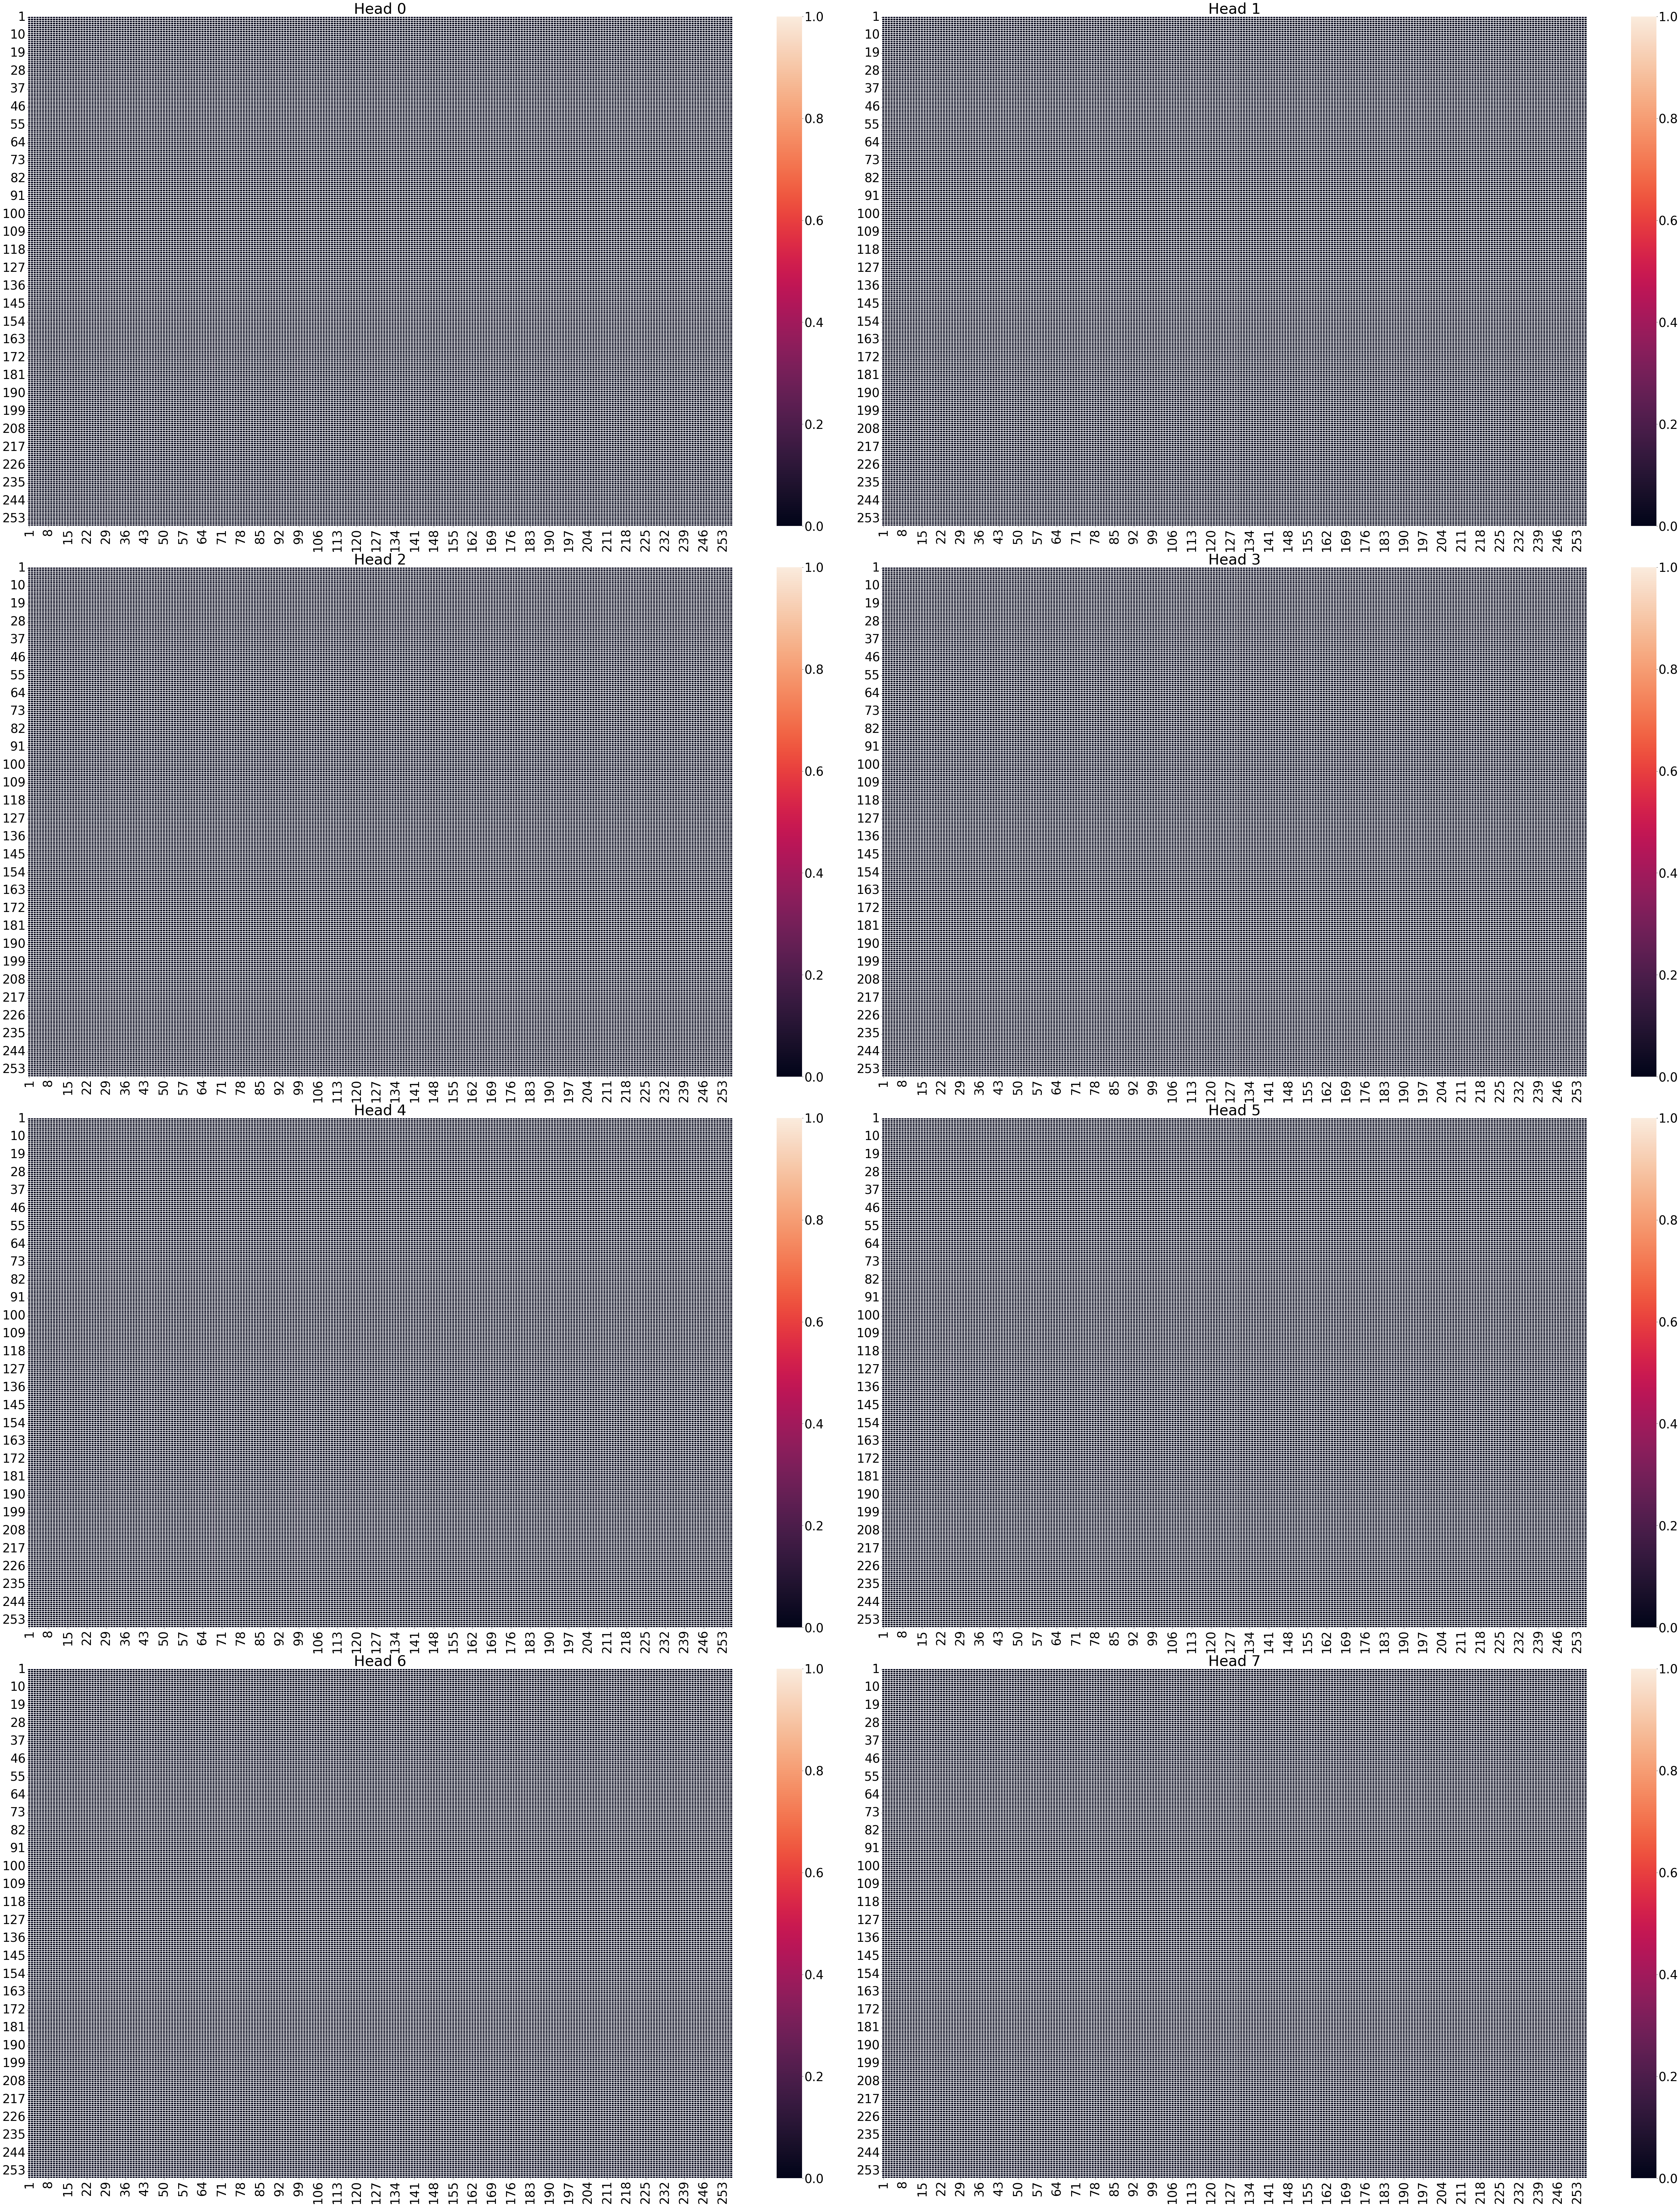

In [36]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 40
plt.rcParams["ytick.labelsize"] = 40
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(4, 2, figsize=(80, 100), sharex=False, sharey=False)

c = 0
for i in range(4):
    for j in range(2):
        df = pd.DataFrame(intra_seg_attn[c].squeeze().detach().cpu().numpy())
        df.rename(columns=intra_seg_pos_map, inplace=True)
        df.rename(index=intra_seg_pos_map, inplace=True)
        sns.heatmap(df, ax=axs[i, j], linewidth=.1, vmin=0, vmax=1)
        axs[i, j].set_title(f"Head {c}")
        c += 1

plt.tight_layout(pad=.1)
plt.show()